# Random Forest Regressor using TA features to Predict BTC future price moves
This notebook is a work in progress. We create features as independent columns in the dataframe. We then try to build a model using a random forest regression to use those features to predict the next N periods into the future for the price change of an asset. The results are pretty impressive so I feel like we are doing something wrong. Feel free to play around with it, I think I documented things in line pretty well so you can play along.

In [3]:
import vectorbt as vbt
import pandas_ta as ta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
import logging
import pickle
from tqdm import tqdm




If you do not have a datafile you can use the notebook `get-data.ipynb` to download some bitcoin data. You can store it in the `/data` folder as `btc.csv`

In [4]:

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

logging.info(f"Loading data")
data = pd.read_csv('../data/btc.csv', index_col=0, parse_dates=True) # I'm using minutely data

# just keep the 'Close' and 'Volume' columns
data = data[['Close', 'Volume']]


2023-03-21 16:35:23,625 - INFO - Loading data


Let's add some features. We will do just a few right now but we can add more later in the notebook

In [7]:
# Create an indicator of the EMA of the close price
ema1_period = 20000
ema2_period = 5000
sma1_period = 10000
sma2_period = 1000
# add the indicators to the dataframe
data.ta.ema(close='Close', length=ema1_period, append=True)
data.ta.ema(close='Close', length=ema2_period, append=True)
data.ta.sma(close='Close', length=sma1_period, append=True)
data.ta.sma(close='Close', length=sma2_period, append=True)
data.dropna(inplace=True)

# Create signals for the EMA and SMA (I was trying to get it into a magnitude format ie. how much is the market above/below the EMA/SMA)
data['ema1_signal'] = (data['Close']/data[f'EMA_{ema1_period}'])-1
data['ema2_signal'] = (data['Close']/data[f'EMA_{ema2_period}'])-1
data['sma1_signal'] = (data['Close']/data[f'SMA_{sma1_period}'])-1
data['sma2_signal'] = (data['Close']/data[f'SMA_{sma2_period}'])-1

# For data checking you can create forecast column for the target variable
forecast = 30 # 30 mins
# data[f'forecast_{forecast}'] = data['Close'].shift(-forecast).pct_change(forecast).dropna()
# data['future'] = data['Close'].shift(-forecast)
# data.dropna(inplace=True)
# If you do the above, be sure to drop the forecast columns when you train the model


df = data.copy()
logging.info(f"Forecasting {forecast} mins fwd.")
logging.info(f'Using {ema1_period} and {ema2_period} ema periods')
logging.info(f'Using {sma1_period} and {sma2_period} sma periods')


2023-03-21 16:37:34,930 - INFO - Forecasting 30 mins fwd.
2023-03-21 16:37:34,931 - INFO - Using 20000 and 5000 ema periods
2023-03-21 16:37:34,932 - INFO - Using 10000 and 1000 sma periods


In [8]:
# Create the features (X) and target (y) data using numpy
X = df[['ema1_signal', 'ema2_signal', 'sma1_signal', 'sma2_signal', 'Volume']].iloc[:-forecast].values # signal and volume
y = df['Close'].pct_change(forecast).dropna().iloc[:-forecast].values.reshape(-1, 1) # future

# Split the data into training and testing sets and make sure they are the same length
min_length = min(len(X), len(y))
X = X[:min_length]
y = y[:min_length]

# Create the model and fit it to the data
logging.info(f"Creating model")
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X, y.ravel()) # Fitting the model takes a few minutes
logging.info(f"Model fitted")
# calculate predictions
y_val = df['Close'].shift(-forecast).pct_change(forecast).dropna() # future
X_val = df[['ema1_signal', 'ema2_signal', 'sma1_signal', 'sma2_signal', 'Volume']][-len(y_val):] # signals and volume
y_val = y_val.values.reshape(-1, 1) # reshape to 2D
# make predictions
logging.info(f"Making predictions")
y_pred = model.predict(X_val.values) # make predictions is pretty quick
logging.info(f"Predictions made")

# remove NaNs and infinities
valid_indices = ~np.isnan(y_pred) & ~np.isnan(y_val.ravel()) # remove NaNs
y_pred = y_pred[valid_indices]
y_val = y_val[valid_indices]


2023-03-21 16:37:38,064 - INFO - Creating model
2023-03-21 16:39:11,143 - INFO - Model fitted
2023-03-21 16:39:11,176 - INFO - Making predictions
2023-03-21 16:39:13,290 - INFO - Predictions made


In [9]:
def calculate_and_print_results(y_val, y_pred, threshold=0.0005):

    mse = mean_squared_error(y_pred, y_val)
    rmse = np.sqrt(mse)
    correct_predictions = np.abs(y_pred - y_val.ravel()) <= threshold
    direction_correct = (np.sign(y_pred) == np.sign(y_val.ravel())).astype(int)
    direction_accuracy = direction_correct.mean() * 100
    accuracy = np.mean(correct_predictions) * 100
    r2 = r2_score(y_val, y_pred)

    print(f"For a threshold of: {threshold}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse:.4f}")
    # print accuracy within 4 decimal places
    print(f"Accuracy: {accuracy:.4f}%")
    print(f"Direction Accuracy: {direction_accuracy:.4f}% This happened {direction_correct.sum()} times out of {len(direction_correct)}")
    print(f"R-squared: {r2:.4f}")
    results = {
        'mse': mse,
        'rmse': rmse,
        'accuracy': accuracy,
        'direction_accuracy': direction_accuracy,
        'r2': r2
    }
    return results

stats = calculate_and_print_results(y_val, y_pred, threshold=0.001)


For a threshold of: 0.001
MSE: 1.1597599470461578e-06
RMSE: 0.0011
Accuracy: 83.3834%
Direction Accuracy: 94.2671% This happened 511633 times out of 542748
R-squared: 0.9467


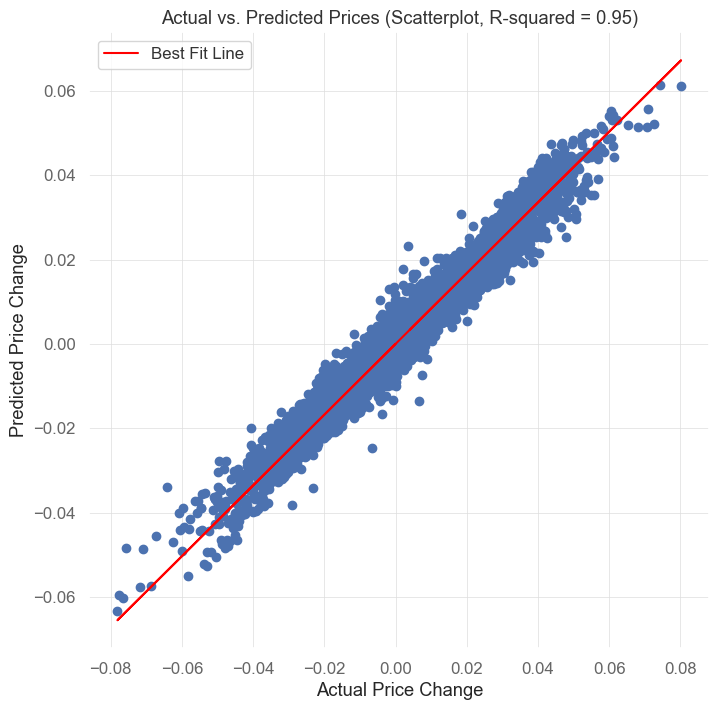

In [10]:
# Create a scatter plot of the predictions versus the actual values
def plot_scatter(y_val, y_pred, r2):

    # Fit a line of best fit to the data
    coeffs = np.polyfit(y_val.ravel(), y_pred.ravel(), 1)
    line = coeffs[0] * y_val.ravel() + coeffs[1]

    # Plot actual vs predicted prices as scatterplot
    plt.figure(figsize=(8, 8))
    plt.scatter(y_val, y_pred)
    plt.xlabel('Actual Price Change')
    plt.ylabel('Predicted Price Change')
    plt.title(f'Actual vs. Predicted Prices (Scatterplot, R-squared = {r2:.2f})')

    # Add best fit line
    plt.plot(y_val.ravel(), line, color='red', label='Best Fit Line')
    plt.legend()

    plt.show()
# Run the function
plot_scatter(y_val, y_pred, stats['r2'])

In [11]:
# Save the model
file_name = f'../models/rf_model_ema{ema1_period}-ema{ema2_period}-sma{sma1_period}-sma{sma2_period}-f{forecast}.pkl'
with open(file_name,  'wb') as file:
    pickle.dump(model, file)

# Create additional features using Pandas_TA
Pandas_ta has a nice capability to create your own indicators as a `Strategy` class. The following are features that I played around with. Read the docs to get ideas here. Just remember, more features -> more time for training and possible garbage. I ran optimizations on the SMA and EMA lengths earlier in a different script to identify some that work pretty well.

In [12]:
momo_bands_sma_ta = [
    {"kind":"sma", "length": 1000},
    {"kind":"sma", "length": 20000},
    {"kind":"ema", "length": 10000},
    {"kind":"ema", "length": 5000},
    {"kind":"bbands", "length": 2000, "ddof": 0},
    {"kind":"macd"},
    {"kind":"rsi"},
    {"kind":"log_return", "cumulative": True},
    {"kind":"sma", "close": "CUMLOGRET_1", "length": 50, "suffix": "CUMLOGRET"},
]
momo_bands_sma_strategy = ta.Strategy(
    "Momo, Bands, MAs and Cumulative Log Returns", # name
    momo_bands_sma_ta, # ta
    "MACD, RSI, Momo with BBANDS and EMAs, SMAs and Cumulative Log Returns" # description
)
momo_bands_sma_strategy

Strategy(name='Momo, Bands, MAs and Cumulative Log Returns', ta=[{'kind': 'sma', 'length': 1000}, {'kind': 'sma', 'length': 20000}, {'kind': 'ema', 'length': 10000}, {'kind': 'ema', 'length': 5000}, {'kind': 'bbands', 'length': 2000, 'ddof': 0}, {'kind': 'macd'}, {'kind': 'rsi'}, {'kind': 'log_return', 'cumulative': True}, {'kind': 'sma', 'close': 'CUMLOGRET_1', 'length': 50, 'suffix': 'CUMLOGRET'}], description='MACD, RSI, Momo with BBANDS and EMAs, SMAs and Cumulative Log Returns', created='Tuesday March 21, 2023, NYSE: 12:35:22, Local: 16:35:22 PDT, Day 80/365 (22.00%)')

Add the new features to the dataframe

In [13]:

data.ta.strategy(momo_bands_sma_strategy, append=True) # Add the new features to the dataframe
data.dropna(inplace=True)
# Print the columns
data.tail()

,Close,Volume,EMA_20000,EMA_5000,SMA_10000,SMA_1000,ema1_signal,ema2_signal,sma1_signal,sma2_signal,...,BBM_2000_2.0,BBU_2000_2.0,BBB_2000_2.0,BBP_2000_2.0,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,RSI_14,CUMLOGRET_1,SMA_50_CUMLOGRET
Open time,,,,,,,,,,,,,,,,,,,,,
2023-02-10 01:21:00+00:00,21848.03,131.29390,22868.844618,22785.656800,23063.973307,22374.02512,-0.044638,-0.041150,-0.052720,-0.023509,...,22593.317185,23317.647947,6.411903,-0.014466,5.279111,-0.705265,5.984377,52.971360,-0.540062,-0.540532
2023-02-10 01:22:00+00:00,21841.65,135.05846,22868.741904,22785.279273,23063.813767,22373.16212,-0.044912,-0.041414,-0.052991,-0.023757,...,22592.801280,23317.802683,6.417986,-0.018034,4.276182,-1.366556,5.642738,48.660380,-0.540354,-0.540505
2023-02-10 01:23:00+00:00,21842.26,95.54590,22868.639261,22784.902141,23063.655320,22372.29928,-0.044882,-0.041371,-0.052958,-0.023692,...,22592.280400,23317.940759,6.423967,-0.016785,3.490341,-1.721918,5.212258,49.087016,-0.540326,-0.540481
2023-02-10 01:24:00+00:00,21849.56,138.73977,22868.537358,22784.528079,23063.498004,22371.44612,-0.044558,-0.041035,-0.052635,-0.023328,...,22591.766175,23318.073193,6.429838,-0.010945,3.417213,-1.436036,4.853249,54.012225,-0.539992,-0.540465
2023-02-10 01:25:00+00:00,21832.77,238.23456,22868.433786,22784.147451,23063.336782,22370.57699,-0.045288,-0.041756,-0.053356,-0.024041,...,22591.246730,23318.237977,6.436044,-0.021655,1.981604,-2.297316,4.278920,43.571878,-0.540761,-0.540468


# Now build a model using the new columns as features


In [14]:
forecast = 10 # minutes into the future to predict
df = data.copy() # split the data into training data
cols = df.columns

# Create the features (X) and target (y) data using numpy
X = df[cols].iloc[:-forecast].values # signal and volume
y = df['Close'].pct_change(forecast).dropna().iloc[:-forecast].values.reshape(-1, 1) # future

# Split the data into training and testing sets and make sure they are the same length
min_length = min(len(X), len(y))
X = X[:min_length]
y = y[:min_length]

# Create the model and fit it to the data
logging.info(f"Fitting model")
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X, y.ravel())
logging.info(f"Model fitted")
y_val = df['Close'].shift(-forecast).pct_change(forecast).dropna() # future
X_val = df[cols][-len(y_val):] # signal and volume
y_val = y_val.values.reshape(-1, 1) # reshape to 2D
# make predictions
logging.info(f"Making predictions")
y_pred = model.predict(X_val.values)
logging.info(f"Predictions made")

# remove NaNs and infinities
valid_indices = ~np.isnan(y_pred) & ~np.isnan(y_val.ravel()) # remove NaNs
y_pred = y_pred[valid_indices]
y_val = y_val[valid_indices]

2023-03-21 16:43:05,423 - INFO - Fitting model
2023-03-21 16:50:27,759 - INFO - Model fitted
2023-03-21 16:50:27,853 - INFO - Making predictions
2023-03-21 16:50:31,049 - INFO - Predictions made


In [ ]:

# Run the function to print the results and store them in a dictionary
print(f"The forecast period is {forecast} minutes")
stats = calculate_and_print_results(y_val, y_pred, threshold=0.001)
# Plot the results
plot_scatter(y_val, y_pred, stats['r2'])

The forecast period is 30 minutes
For a threshold of: 0.001
MSE: 1.2290406282880485e-05
RMSE: 0.0035
Accuracy: 43.5594%
Direction Accuracy: 75.5010% This happened 409780 times out of 542748
R-squared: 0.4351


# Train the model on only a portion of the data then validate it
Up until this point we have been cheating a little bit, even though we are splitting our data into training and testing we haven't really been `validating` our results on data that was never seen. 

Below, we will split the data up into a batch of training data (this will still randomly create train/test splits) but we will also validate the model on data that it has never seen before. We would expect the model accuracy to come down significantly, but hopefully there is still some predictive power in what we have created.

2023-03-21 15:55:50,924 - INFO - Fitting model
2023-03-21 16:03:03,114 - INFO - Model fitted
2023-03-21 16:03:03,232 - INFO - Making predictions
2023-03-21 16:03:06,574 - INFO - Predictions made


The forecast period is 10 minutes
For a threshold of: 0.001
MSE: 4.538244185611519e-07
RMSE: 0.0007
Accuracy: 90.4954%
Direction Accuracy: 93.0930% This happened 454750 times out of 488490
R-squared: 0.9417


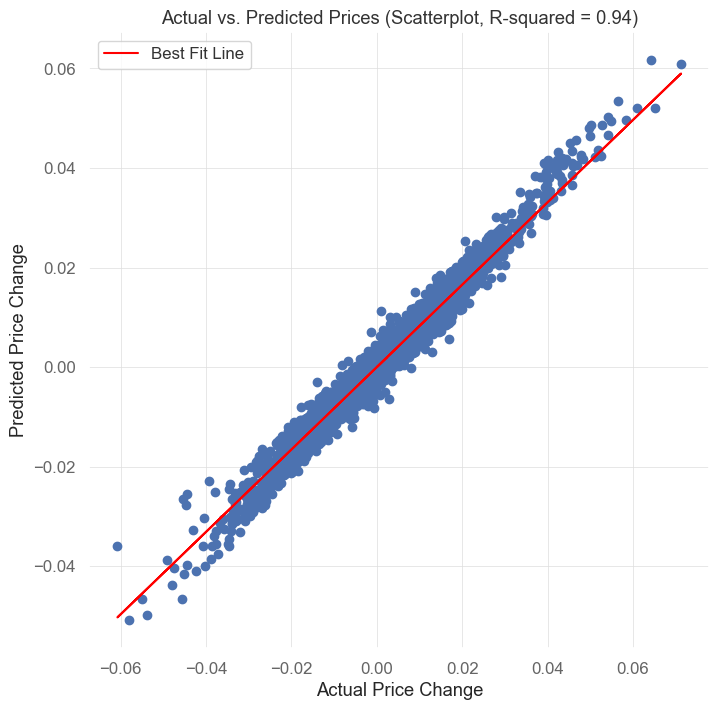

In [ ]:
forecast =  10# minutes into the future to predict
data_filter = len(data)*0.90 # 90% of the data will be used for training

# Split the data up so se can build a model on the training data and test it on the validation data
train_df = data.iloc[:int(data_filter)] # training data
validation_df = data.iloc[int(data_filter):] # validation data
cols = df.columns

# Create the features (X) and target (y) data using numpy
X = train_df[cols].iloc[:-forecast].values # grab all the columns except the `forecast` column
y = train_df['Close'].pct_change(forecast).dropna().iloc[:-forecast].values.reshape(-1, 1) # future

# Split the data into training and testing sets and make sure they are the same length
min_length = min(len(X), len(y))
X = X[:min_length]
y = y[:min_length]

# Create the model and fit it to the data
logging.info(f"Fitting model")
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X, y.ravel())
logging.info(f"Model fitted")
y_val = train_df['Close'].shift(-forecast).pct_change(forecast).dropna() # future
X_val = train_df[cols][-len(y_val):] # features but only the last rows
y_val = y_val.values.reshape(-1, 1) # reshape to 2D
# make predictions
logging.info(f"Making predictions")
y_pred = model.predict(X_val.values)
logging.info(f"Predictions made")

# remove NaNs and infinities
valid_indices = ~np.isnan(y_pred) & ~np.isnan(y_val.ravel()) # remove NaNs
y_pred = y_pred[valid_indices]
y_val = y_val[valid_indices]

# Show the results of the trained model
# Run the function to print the results and store them in a dictionary
print(f"The forecast period is {forecast} minutes")
stats = calculate_and_print_results(y_val, y_pred, threshold=0.001)
# Plot the results
plot_scatter(y_val, y_pred, stats['r2'])

# Test the model on completely unseen data
I would not expect much here but this is the true test of the model. 

Note this almost always works better when the forecast prediction period is shorter. This should be intuitive, it is easier to predict the direction of bitcoin over the next 5 to 10 minutes than it is over the next 8 hours. 

In [ ]:

# Test the model on the validation data
validation_df = data.iloc[int(data_filter):] # validation data
cols = validation_df.columns
logging.info(f"Applying model to validation data")
y_val = validation_df['Close'].shift(-forecast).pct_change(forecast).dropna() # future
X_val = validation_df[cols][-len(y_val):] # adds all the feature columns that we were using before and ignores the forecast column
y_val = y_val.values.reshape(-1, 1) # reshape to 2D
# make predictions
logging.info(f"Making predictions")
y_pred = model.predict(X_val.values) # uses the feature columns to make predictions on the future price movement
logging.info(f"Predictions made")

# remove NaNs and infinities
valid_indices = ~np.isnan(y_pred) & ~np.isnan(y_val.ravel()) # remove NaNs
y_pred = y_pred[valid_indices]
y_val = y_val[valid_indices]

# Calculate and print the results
stats = calculate_and_print_results(y_val, y_pred, threshold=0.001)
# Plot the results
plot_scatter(y_val, y_pred, stats['r2'])

2023-03-21 15:51:30,036 - INFO - Applying model to validation data
2023-03-21 15:51:30,048 - INFO - Making predictions


ValueError: Found array with 0 sample(s) (shape=(0, 25)) while a minimum of 1 is required by RandomForestRegressor.

We may want to give the full history to the model to make predictions. I'm not sure how much is enough. In the above example we did not give it any original data to test the predictions. In practice we wouldn't do this. We would always have historial data to let the model see in order to make predictions.

In [ ]:
# Test the model on the full dataset

forecast = 30 # minutes into the future to predict
data_filter = len(data)*1.00 # 100% of the data will be used for training
df = data.iloc[:int(data_filter)] # full data
cols = df.columns

# Create the features (X) and target (y) data using numpy
X = df[cols].iloc[:-forecast].values # signal and volume
y = df['Close'].pct_change(forecast).dropna().iloc[:-forecast].values.reshape(-1, 1) # future

# Split the data into training and testing sets and make sure they are the same length
min_length = min(len(X), len(y))
X = X[:min_length]
y = y[:min_length]

# Use the model on the full dataset
logging.info(f"Applying model to full dataset")
y_val = df['Close'].shift(-forecast).pct_change(forecast).dropna() # future
X_val = df[cols][-len(y_val):] # signal and volume
y_val = y_val.values.reshape(-1, 1) # reshape to 2D
# make predictions
logging.info(f"Making predictions")
y_pred = model.predict(X_val.values)
logging.info(f"Predictions made")

# remove NaNs and infinities
valid_indices = ~np.isnan(y_pred) & ~np.isnan(y_val.ravel()) # remove NaNs
y_pred = y_pred[valid_indices]
y_val = y_val[valid_indices]

calculate_and_print_results(y_val, y_pred, threshold=0.001)
plot_scatter(y_val, y_pred, stats['r2'])

NameError: name 'data' is not defined